## 21.05.01 주간발표
- Process에 대한 이해 점검
- 텍스트 데이터를 통한 예시

<hr>



### 1. Preprocessing
- Voice To Wave Characteristic
    - Fourier Transform 을 이용한 벡터 추출
    - 한 음성파일의 전체에 대한 파형이든, 초단위로 본 해당 음성의 데이터 든   
    
    
- Text 기반 (Voice to Text, 스미싱)
    - STT (ETRI) 방식을 이용한 텍스트 추출 and 문자 에서 텍스트 추출(MFCC, STFT -> Frequency)
    - 텍스트를 특정 전처리 방식 (현재는 글자 단위의 유니코드 임베딩)을 통한 벡터 추출   
    

- Picture To Characteristic(화상전화 전처리)
    - **Discrete Fourier Transform 알고리즘을 활용하여 Picture에서 함수벡터인 Characteristic로 전처리**   
    

#### 1번 단에서의 Output
- 전처리 된 Voice vector
- 전처리 된 텍스트 vector
- 전처리 된 Image 관련 벡터

### 2. MCMC 샘플링
- 현재의 Output은 하나의 데이터에 대한 Vector
    - 텍스트면 한 문자 메시지 한통
    - 음성은 초단위별 값? / 음성 한통에 대한 값?
- 이 각각의 벡터 데이터들의 각각에 대한 MCMC 샘플링을 통한 각각의 분포 생성
    - 질문) 생성된 분포를 사후확률이라고 하는지? 사전확률?

### 3. 분포 합
- 생겨진 각각의 분포들을 더해 최종 구축된 사전확률을 만듬. 

### 4. Varational Inference (KLD) 
- 실제 데이터가 들어오고, 실시간으로 Variational Inference를 이용한 분포 생성
- 쿨백-라이블러 발산(Kullback–Leibler divergence, KLD)을 통한 사후확률-사전확률간의 분포 차이 비교

### 질문)
- 실시간으로 분포를 만든다?

<hr>

## 1. Text Preprocessing
- 텍스트를 글자별로 Unicode로 변환 및 Vector 정규화

- 원본 텍스트 
    - "안녕하세요. 저는 이정수 입니다."
- 벡터화
    - [0.4, -1.46, 1.89, 0.02, 0.52, 0.65, -1.34, 0.6, 0.66, 0.1, 0.61, -1.32, -1.31]

In [47]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

text_vec = np.array([0.4, -1.46, 1.89, 0.02, 0.52, 0.65, -1.34, 0.6, 0.66, 0.1, 0.61, -1.32, -1.31])
v_m = text_vec.mean()
v_std = text_vec.std()
print('평균:', v_m, '표준편차:', v_std)

평균: 0.0015384615384615228 표준편차: 0.9995679540054073


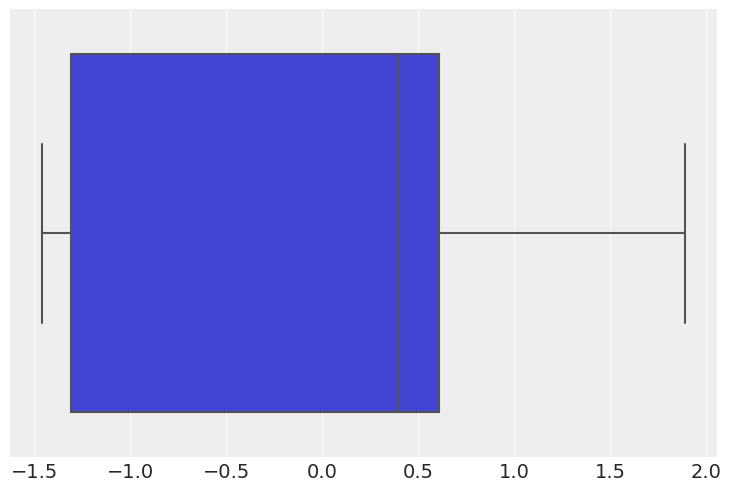

In [48]:
# Boxplot
import seaborn as sns
ax = sns.boxplot(text_vec)

## 2. MCMC Sampling 을 통한 분포 생성
- 정규화를 진행했으니 정규분포에 가깝다고 할 수 있음
- 정규분포를 활용한 Sampling
- NUTS 샘플러(No U-Turn Sampler) 
    - 학습시간에 효율적 

- 2개의 Chain으로 1000번 학습

In [49]:
# Model Context 생성
with pm.Model() as model:

    # Continuous model
    mu = pm.Normal("mu", mu=v_m, sigma=v_std)
    obs = pm.Normal("obs", mu=mu, sigma=v_std, observed=text_vec)

    # Posterior 에서 1000개의 Sample 추출,
    # 샘플러가 추가로 500번 반복하여 매개 변수 조정
    idata = pm.sample(10000, tune=2000, return_inferencedata=True)

idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 2_000 tune and 10_000 draw iterations (4_000 + 20_000 draws total) took 53 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [50]:
# common metric, R-hat, as Gelman-Rubin statistic
# r_hat이 1에 가까워지면 마르코프 체인이 수렴한다는 것을 의미
import arviz as az
az.style.use("arviz-darkgrid")

az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.0,0.268,-0.5,0.505,0.003,0.002,9700.0,14041.0,1.0


#### Gelman-Rubin statistic - r_hat이 1에 가까워지면 마르코프 체인이 수렴한다는 것을 의미

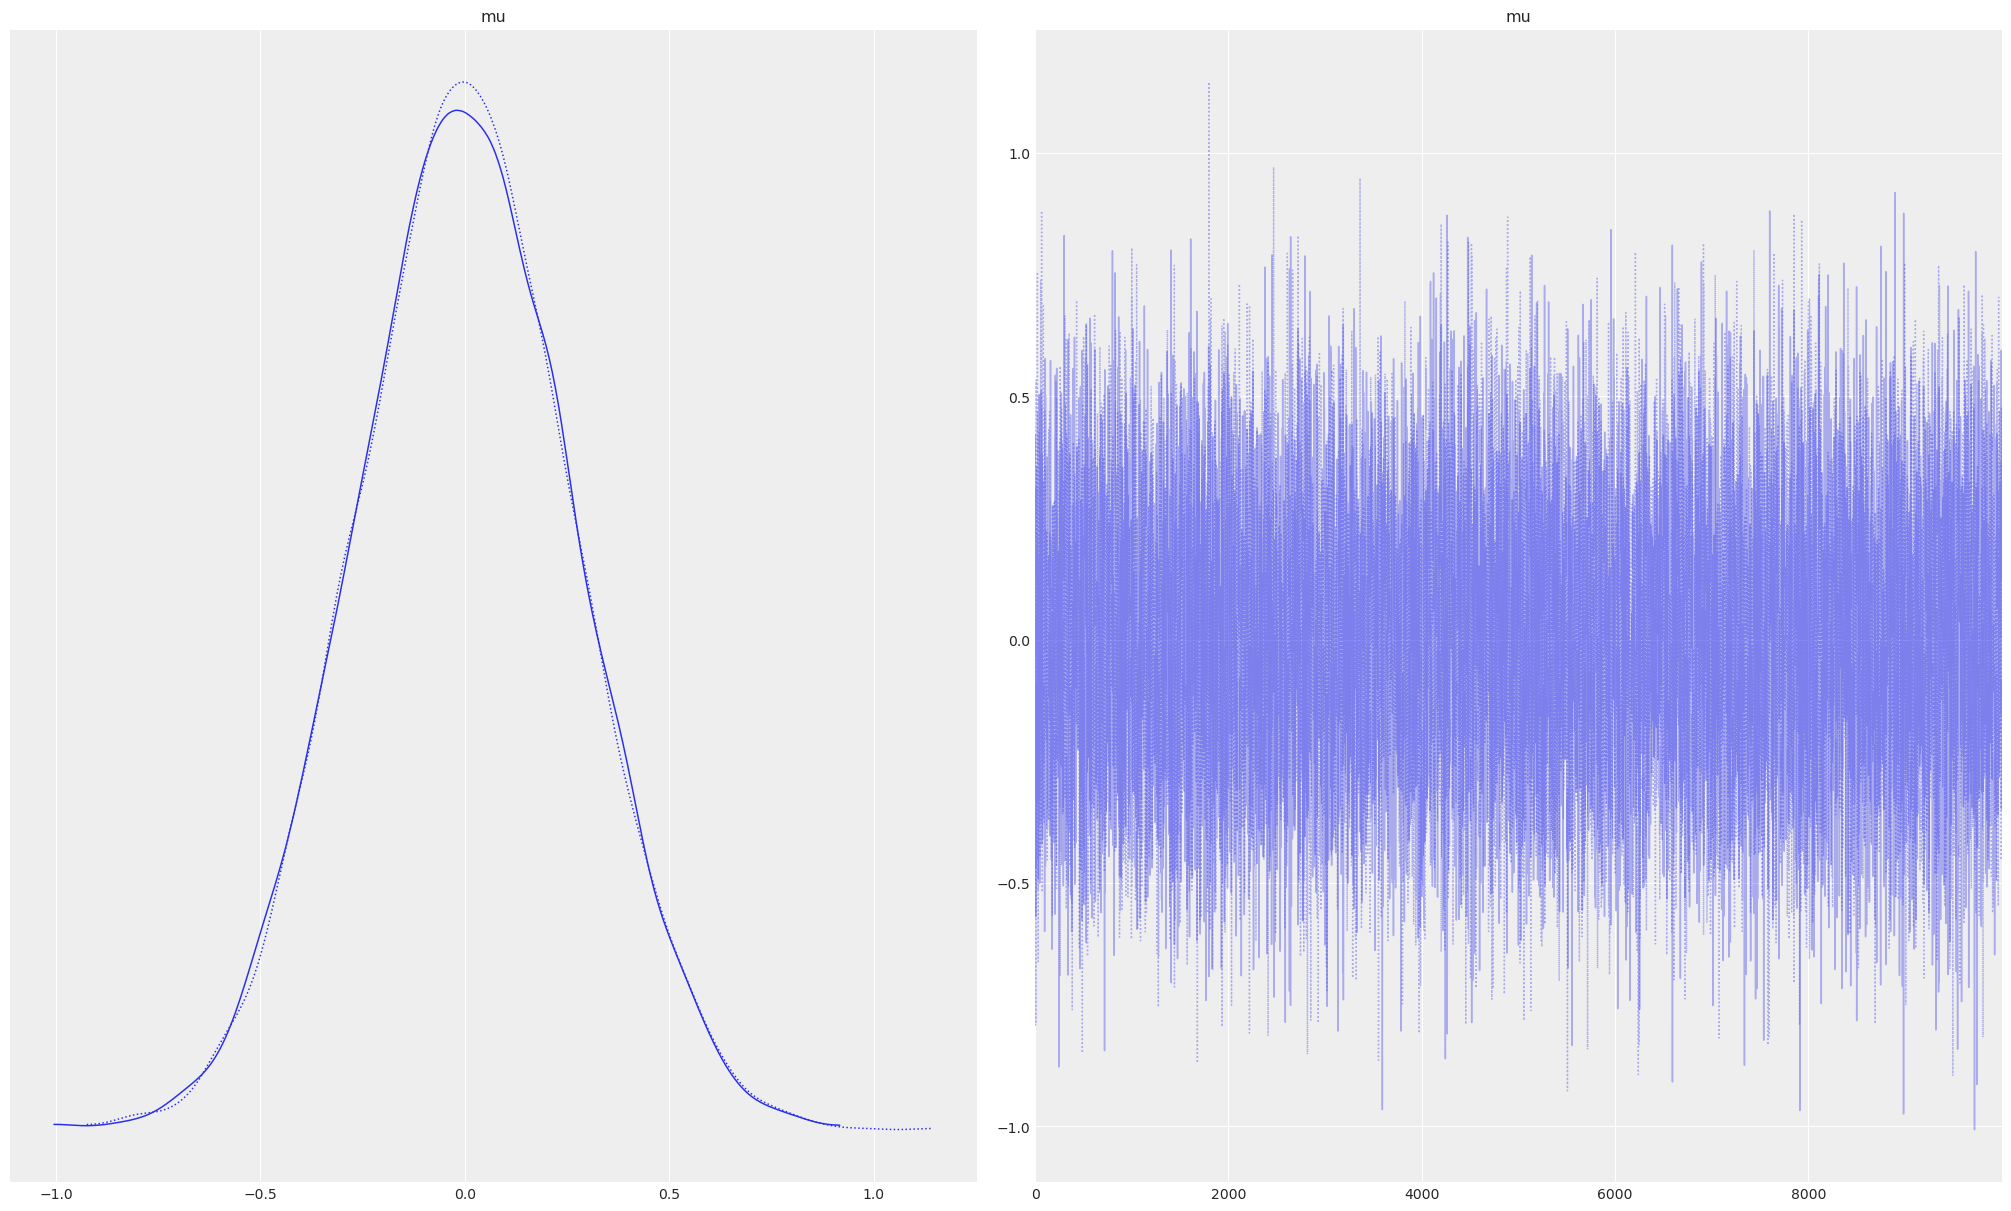

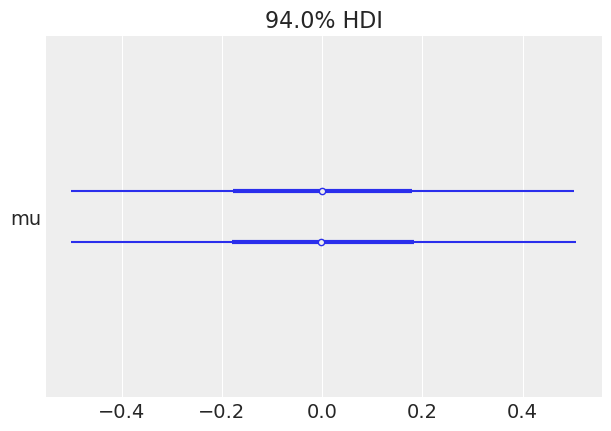

In [51]:
# 2개의 Chain에 대해 분포
import arviz as az
az.style.use("arviz-darkgrid")
az.plot_trace(idata, figsize=(20,12)); # 각각의 Chain에 대한 값들

# forestplot
az.plot_forest(idata, r_hat=False);

## 3. 신규 데이터에 대한 Variational Inference
- 앞에 3개 vector 값만 변경 
- Variational Inference 진행
- (진행중) KL Divergence를 이용한 기존 사전 확률 분포와 사후 확률 분포와의 차이 구함

In [52]:
# 앞에 3개 값만 변경
text_vec2 = np.array([0.4, -1.46, 1.89, 0.02, 0.52, 0.65, -1.34, 0.6, 0.66, 0.1, 0.61, -1.32, -1.31])
v_m2 = text_vec2.mean()
v_std2 = text_vec2.std()
print('평균:', v_m2, '표준편차:', v_std2)

평균: 0.0015384615384615228 표준편차: 0.9995679540054073


In [53]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=v_m2, sigma=v_std2)
    obs = pm.Normal("obs", mu=mu, sigma=v_std2, observed=text_vec2)

    approx = pm.fit(method="fullrank_advi") # default meanfield

Finished [100%]: Average Loss = 19.764


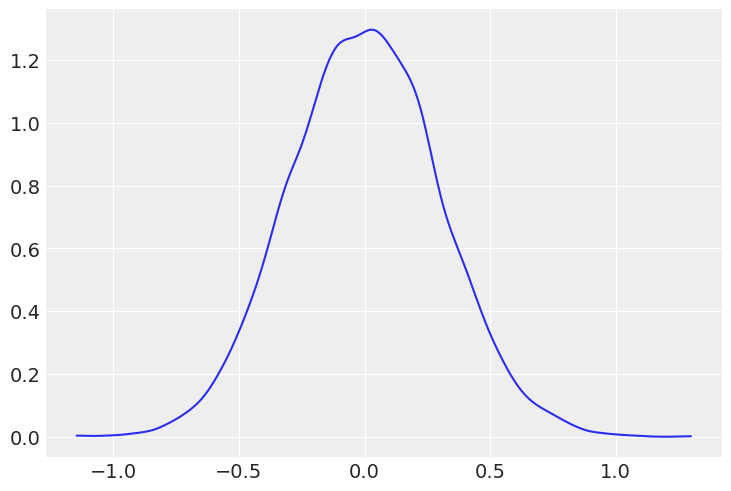

In [54]:
plt.figure()
trace = approx.sample(10000)
az.plot_dist(trace["mu"]);

### KL Divergence (진행중)
- 위 mcmc 그래프와 vi 그래프간의 KLD를 통한 차이 계산

## 참고문헌
- https://datascienceschool.net/03%20machine%20learning/19.01%20%EB%AA%AC%ED%85%8C%EC%B9%B4%EB%A5%BC%EB%A1%9C%20%EB%B2%A0%EC%9D%B4%EC%A7%80%EC%95%88%20%EB%B6%84%EC%84%9D.html